In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float

%matplotlib inline


In [2]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [3]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [4]:
def parametricSolutions(t, nn, t0, x1):
    # parametric solutions 
    N1,N2 = nn(t)
    dt =t-t0
#### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt 
    f = (1-torch.exp(-dt))*(1-torch.exp(dt-12))
#     f=dt
    psi_hat  = x1  + f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):

    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx/2 + (E-V)*psi
    L  = (f.pow(2)).mean(); 
    return L

In [5]:
class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
        
        # define layers
        #self.Lin_1   = torch.nn.Linear(1, D_hid)
        #self.E_out = torch.nn.Linear(D_hid, 1)
        #self.Lin_2 = torch.nn.Linear(D_hid, D_hid)
        #self.Ein = torch.nn.Linear(1,1)
        #self.Lin_out = torch.nn.Linear(D_hid+1, 1)
        
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))
        L1 = self.Lin_1(torch.cat((t,In1),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1

In [6]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point
  k = 4

  Xsnp = Xs.data.numpy()
  Vnp = k*Xsnp**2/2
  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



In [7]:
# Train the NN
def run_Scan_oscillator(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    fc0 = qNN1(neurons)
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    EWall_history = []
    di = (None, 1e+20)
    dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di , 6:di, 7:di, 8:di, 9:di, 10:di, 11:di, 12:di, 13:di, 14:di, 15:di, 16:di}
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -2
    last_psi_L = 0
    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
# Perturbing the evaluation points & forcing t[0]=t0
        t=perturbPoints(grid,t0,tf,sig=.03*tf)
            
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0


        for nbatch in range(minibatch_number): 
# batch time set
            t_mb = t_b[batch_start:batch_end]

#  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1) #- last_psi_L*torch.exp(-(torch.ones_like(t_mb)-1)**2/(2*(1/20)))
            #last_psi_L = parametricSolutions(torch.ones_like(t_mb),fc0,t0,x1).data.numpy()[0][0]
            #print(last_psi_L)
            Pot = potential(t_mb)
            Ltot = hamEqs_Loss(t_mb, psi, En, Pot)
            SE_loss_history.append(Ltot) #
            
            criteria_loss =  Ltot

            if tt%1000 == 0:
              walle += 0.16
            Ltot += 1/((psi.pow(2)).mean()+1e-6) + 1/(En.pow(2).mean()+1e-6) + torch.exp(-1*En+walle).mean()
            En_loss_history.append(torch.exp(-1*En+walle).mean()) #
            EWall_history.append(walle)

            
            nontriv_loss_history.append(1/((psi.pow(2)).mean()+1e-6)) #
            Ennontriv_loss_history.append(1/(En.pow(2).mean()+1e-6)) #
# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)       

#Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss

        E_bin = abs(En[0].data.tolist()[0]//2) 
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss)

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic)
    return fc1, loss_histories, runTime

In [8]:
## Train the model 

t0 = -6
tf = 6
xBC1=0.

n_train, neurons, epochs, lr,mb = 1200, 50, int(5e4), 8e-3, 1 
model1,loss_hists1,runTime1 = run_Scan_oscillator(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

In [ ]:
aarg = np.argmin(loss_hists1[6])

In [11]:
import pickle

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
imgdir = '/content/gdrive/My Drive/Harvard IACS Research/Plotting Data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [13]:
pickle.dump((model1,loss_hists1,runTime1), open(imgdir+'har_plot_data.sav','wb'))

In [ ]:
pickle.dump(loss_hists1[1],open(imgdir+'har_dic.sav','wb'))

In [ ]:
loss_hists1 = loss_hists1[3:]

In [ ]:
pickle.dump(loss_hists1,open(imgdir+'har_plot_data.sav','wb'))

In [ ]:
loss_hists1 = 0

Training time (minutes): 9.662886691093444


Text(0.5, 24.3, 'Epochs')

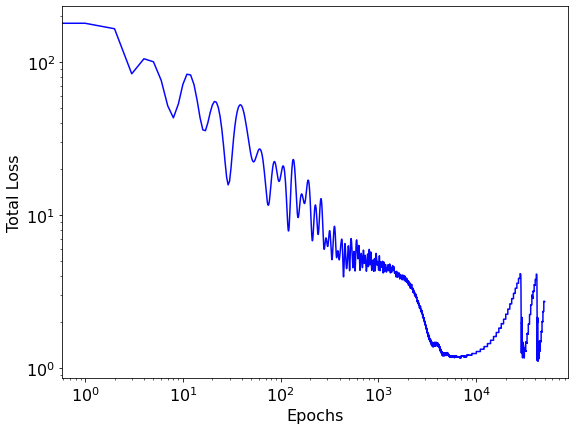

In [9]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'harmonic_total_loss.png', bbox_inches = 'tight')

In [16]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1,t0,xBC1) 
psi=psi.data.numpy(); 


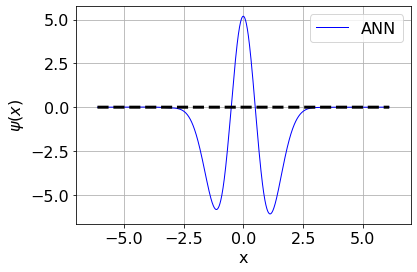

In [17]:
#tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-7,7)
#
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
#plt.plot(t_net, 8*t_net**2/2)


tensor(5.0592, grad_fn=<SelectBackward>)

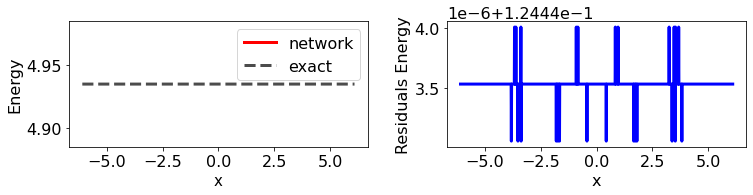

In [18]:
E1 = np.pi**2/2 # ground
p,e=model1(tTest)
#ed = dfx(tTest,e)

plt.figure(figsize=[16,3])
### 
plt.subplot(1,3,1)
plt.plot(t_net, e.data.numpy(), '-r', label='network', linewidth=3)
plt.plot(t_net, E1*t_net/t_net, '--k', label='exact', linewidth=3, alpha=0.7)
plt.ylim([0.99*E1, 1.01*E1])

plt.legend()
plt.xlabel('x',fontsize=15)
plt.ylabel('Energy')
###

plt.subplot(1,3,2)
plt.plot(t_net, e.data.numpy()-E1*t_net/t_net, '-b', linewidth=3)
# plt.ylim([-1e-3, 1e-3])
plt.xlabel('x')
plt.ylabel('Residuals Energy')

#plt.subplot(1,3,3)
#plt.plot(t_net, ed.data.numpy(),'b', linewidth=3)
#plt.xlabel('x')
#plt.ylabel('d/dx Energy')

plt.tight_layout()
e[0][0]

Text(0.5, 6.300000000000001, 't')

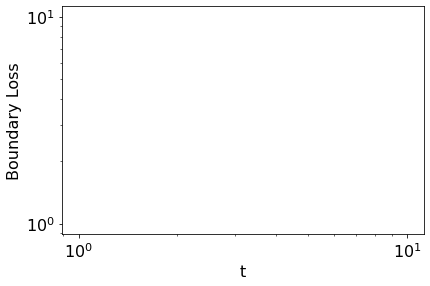

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[1],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Boundary Loss');plt.xlabel('t')

NameError: ignored

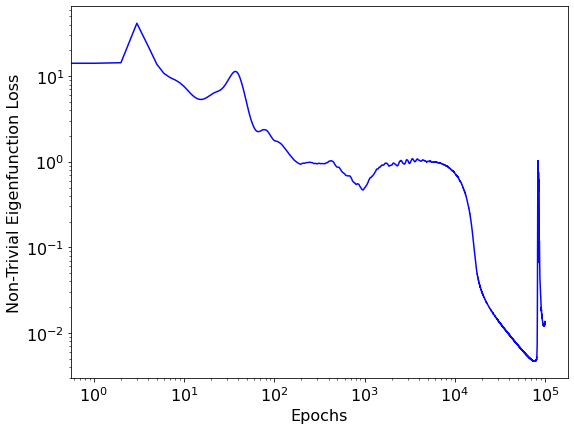

In [13]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Eigenfunction Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_nontrivfunc_loss.png', bbox_inches = 'tight')

NameError: ignored

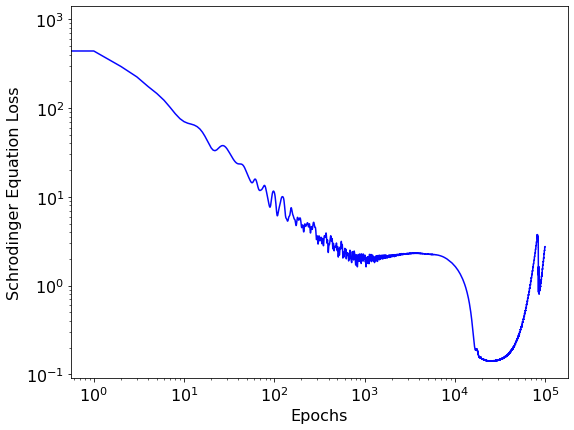

In [14]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[3],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_SE_loss.png', bbox_inches = 'tight')

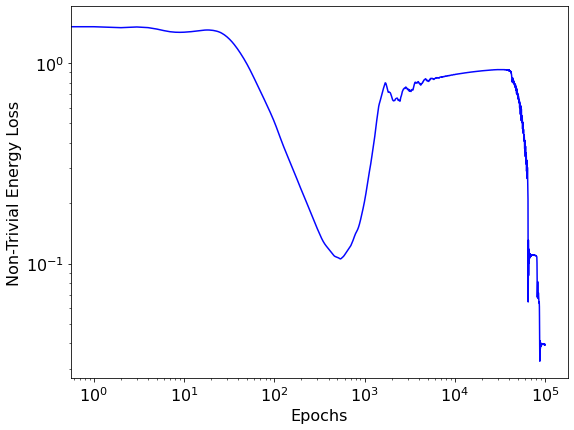

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[4],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Energy Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_nontrivE_loss.png', bbox_inches = 'tight')

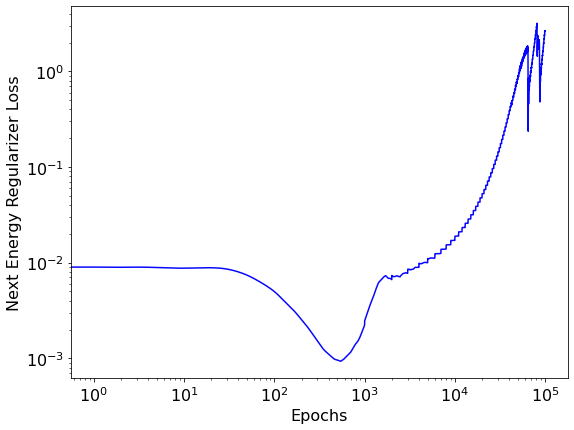

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[5],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Next Energy Regularizer Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_nextE_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 't')

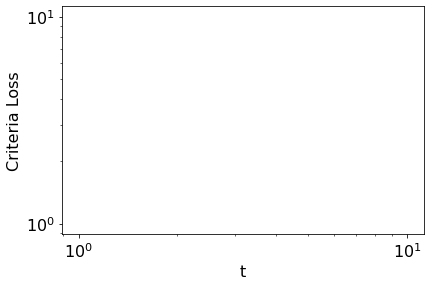

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[6],'-b',alpha=0.975);
#plt.axvline(x = np.argmin(loss_hists1[6]))
plt.tight_layout()
plt.ylabel('Criteria Loss');plt.xlabel('t')

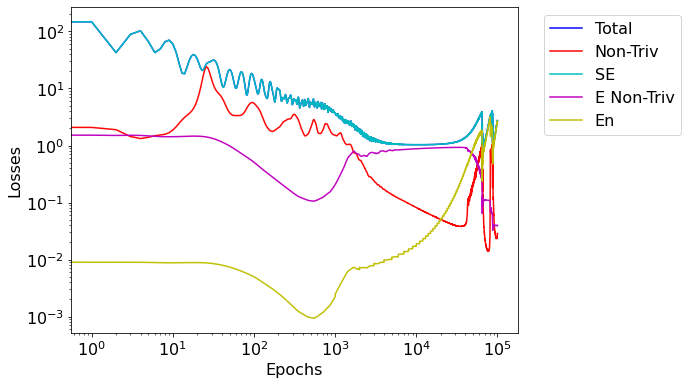

In [ ]:
# Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history
plt.figure(figsize =(8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975, label = 'Total');
#plt.loglog(loss_hists1[1],'-g',alpha=0.975, label = 'Boundary');
plt.loglog(loss_hists1[2],'-r',alpha=0.975, label = 'Non-Triv');
plt.loglog(loss_hists1[3],'-c',alpha=0.975, label = 'SE');
plt.loglog(loss_hists1[4],'-m',alpha=0.975, label = 'E Non-Triv');
plt.loglog(loss_hists1[5],'-y',alpha=0.975, label = 'En');
#plt.loglog(loss_hists1[6],'-k',alpha=0.975, label = 'Criteria');
#plt.axvline(x = aarg)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses'); plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_all_loss.png', bbox_inches = 'tight')

NameError: ignored

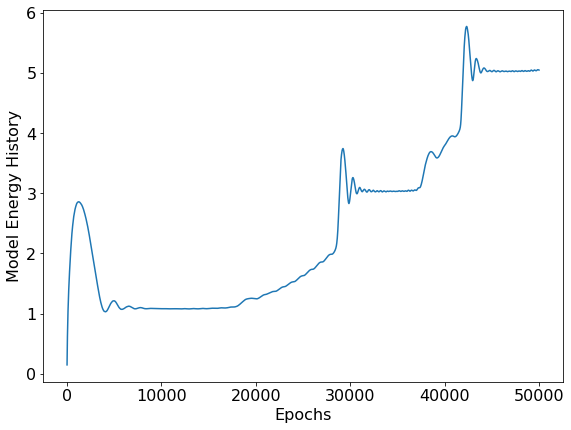

In [10]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_modelE_hist.png', bbox_inches = 'tight')

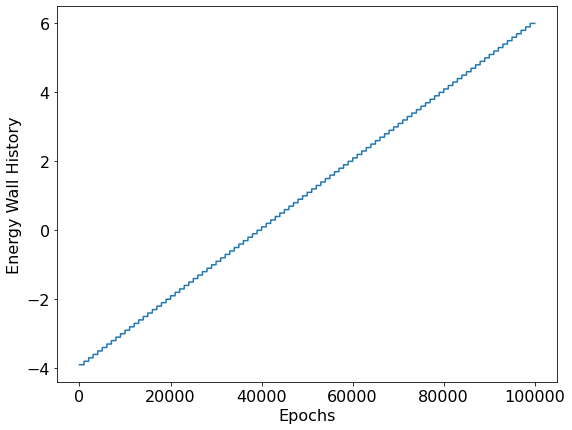

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[9])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Energy Wall History');plt.xlabel('Epochs')
plt.savefig(imgdir+'harmonic_Ewall_hist.png', bbox_inches = 'tight')

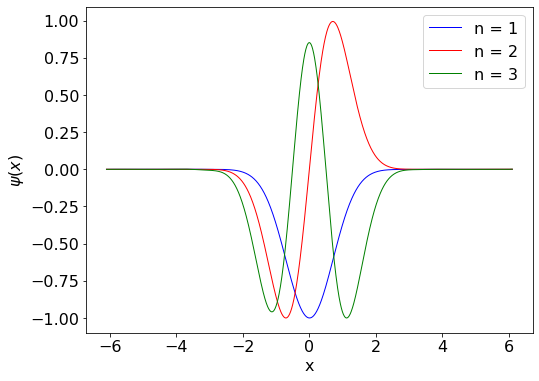

In [19]:
plt.figure(figsize = (8,6))
psi_0to10 = parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1)
psi_10to20 = parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1)
psi_20to30 = parametricSolutions(tTest,loss_hists1[10][2][0],t0,xBC1)
#psi_30to40 = parametricSolutions(tTest,loss_hists1[10][3][0],t0,xBC1)

plt.plot(t_net, 1*psi_0to10.data.numpy()/np.max(np.abs(psi_0to10.data.numpy())), '-b', linewidth=1, label = 'n = 1')
plt.plot(t_net, 1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy())), '-r', linewidth=1, label = 'n = 2')
plt.plot(t_net, 1*psi_20to30.data.numpy()/np.max(np.abs(psi_20to30.data.numpy())), '-g', linewidth=1, label = 'n = 3')
#plt.plot(t_net, 1*psi_30to40.data.numpy(), '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.ylabel('$\psi(x)$'); plt.xlabel('x')
plt.savefig(imgdir+'harmonic_eigenfuncs.png', bbox_inches = 'tight')

In [20]:
print(loss_hists1[10][0][0].forward(tTest)[1][0])
print(loss_hists1[10][1][0].forward(tTest)[1][0])
print(loss_hists1[10][2][0].forward(tTest)[1][2])
#print(loss_hists1[10][3][0].forward(tTest)[1][4])


tensor([1.1037], grad_fn=<SelectBackward>)
tensor([3.0620], grad_fn=<SelectBackward>)
tensor([5.0592], grad_fn=<SelectBackward>)


# Error Analysis

## Ground state

Mean Squared Error: 1.0747946e-08


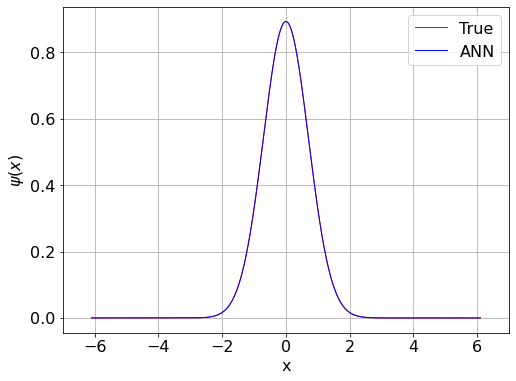

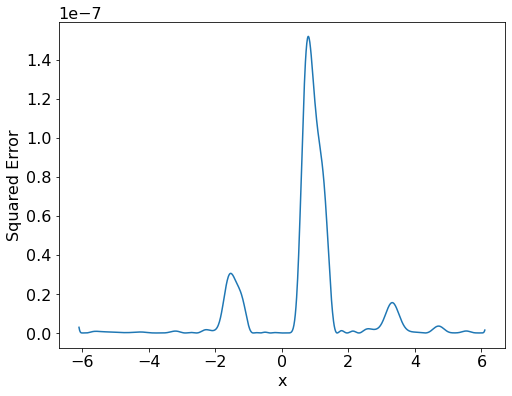

In [ ]:
plt.figure(figsize = (8,6))
psi =parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1) 
psi=psi.data.numpy(); 
tru = (2/np.pi)**0.25*np.exp(-(2**0.5*tTest.data.numpy())**2/2)
plt.plot(t_net, tru, '-r', linewidth=1, label = 'True')

plt.xlim(-7,7)
plt.plot(t_net, 1*psi/np.max(np.abs(psi))*np.max(tru), '-b', linewidth=1, label = 'ANN')
plt.legend()
#plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.savefig(imgdir+'harmonic_ground.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
plt.plot(t_net, (tru-psi/np.max(np.abs(psi))*np.max(tru))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean((tru-psi/np.max(np.abs(psi))*np.max(tru))**2)))
plt.savefig(imgdir+'harmonic_ground_err.png', bbox_inches = 'tight')


## First Excited

Mean Squared Error: 2.1005843e-07


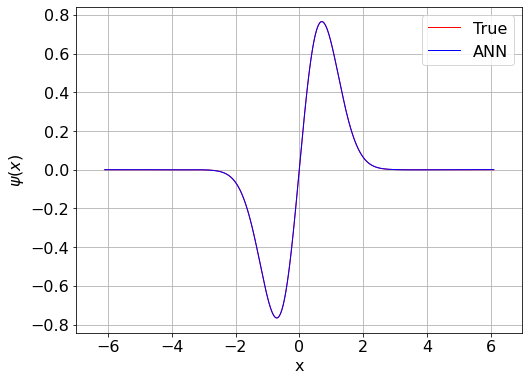

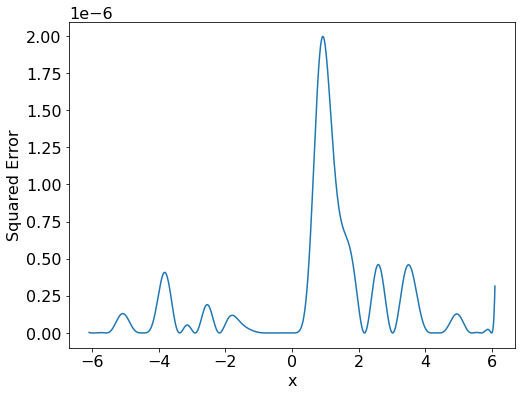

In [ ]:
plt.figure(figsize = (8,6))
psi =parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1) 
psi=psi.data.numpy(); 
tru = (2/np.pi)**0.25*np.exp(-(2**0.5*tTest.data.numpy())**2/2)*2**0.5*2**0.5*tTest.data.numpy()
plt.plot(t_net, tru, '-r', linewidth=1, label = 'True')

plt.xlim(-7,7)
plt.plot(t_net, -1*psi/np.max(np.abs(psi))*np.max(tru), '-b', linewidth=1, label = 'ANN')
plt.legend()
#plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.savefig(imgdir+'harmonic_first.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
plt.plot(t_net, (tru+psi/np.max(np.abs(psi))*np.max(tru))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean((tru+psi/np.max(np.abs(psi))*np.max(tru))**2)))
plt.savefig(imgdir+'harmonic_first_err.png', bbox_inches = 'tight')


## Second Excited

Mean Squared Error: 1.1283397e-06


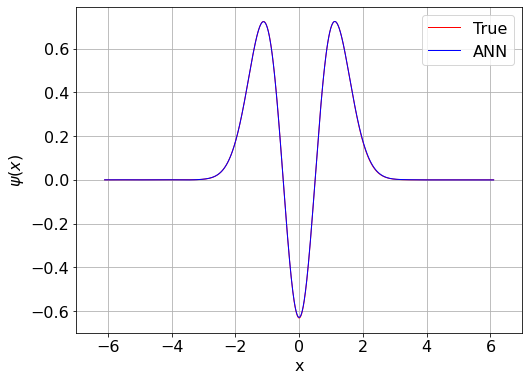

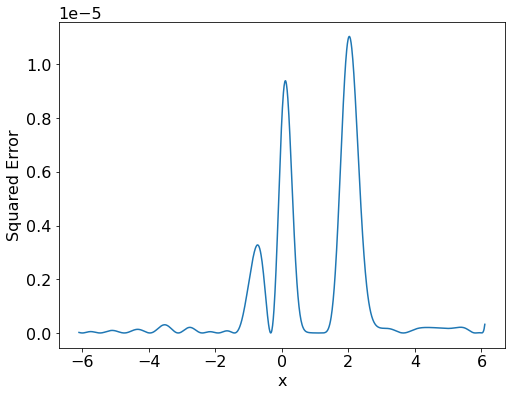

In [ ]:
plt.figure(figsize = (8,6))
psi =parametricSolutions(tTest,loss_hists1[10][2][0],t0,xBC1) 
psi=psi.data.numpy(); 
tru = (2/np.pi)**0.25*np.exp(-(2**0.5*tTest.data.numpy())**2/2)*2**-0.5*(2*(2**0.5*tTest.data.numpy())**2-1)
plt.plot(t_net, tru, '-r', linewidth=1, label = 'True')

plt.xlim(-7,7)
plt.plot(t_net, 1*psi/np.max(np.abs(psi))*np.max(tru), '-b', linewidth=1, label = 'ANN')
plt.legend()
#plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.savefig(imgdir+'harmonic_second.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
plt.plot(t_net, (tru-psi/np.max(np.abs(psi))*np.max(tru))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean((tru-psi/np.max(np.abs(psi))*np.max(tru))**2)))
plt.savefig(imgdir+'harmonic_second_err.png', bbox_inches = 'tight')
